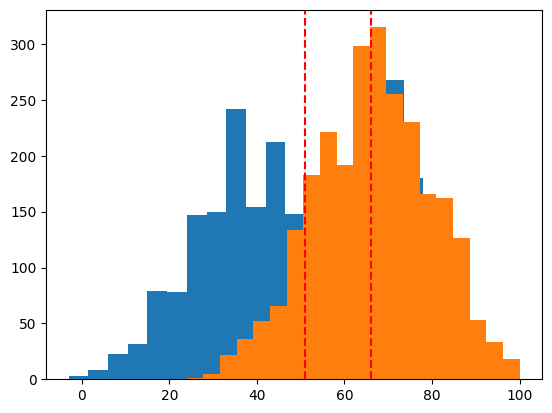

Temperature Median of Training Set: 51.0
Humidity Median of Training Set: 66.0


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("daily_data.csv")

# Ignore the last 100 rows
df = df[:-100]

# Calculate medians
temp_median = df["DailyAverageDryBulbTemperature"].median()
humidity_median = df["DailyAverageRelativeHumidity"].median()

# Plot temperature histogram
plt.hist(df["DailyAverageDryBulbTemperature"], bins=20)
plt.axvline(temp_median, color='red', linestyle='dashed')

# Plot humidity histogram
plt.hist(df["DailyAverageRelativeHumidity"], bins=20)
plt.axvline(humidity_median, color='red', linestyle='dashed')

# Show the plots
plt.show()

# Print the median values
print("Temperature Median of Training Set:", temp_median)
print("Humidity Median of Training Set:", humidity_median)

In [12]:
df = pd.read_csv("daily_data.csv",usecols=[11, 12,24,25])
df = df[:-100]

# Consider the T(small amount of rain or snow) value for precipitation and Snow as 0.00/no precipitation and snow
df["DailyPrecipitation"] = df["DailyPrecipitation"].replace("T", 0.00).astype(float)
df["DailySnowDepth"] = df["DailySnowDepth"].replace("T", 0.00).astype(float)
df

,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyPrecipitation,DailySnowDepth
0,25.0,46.0,0.00,0.0
1,32.0,57.0,0.00,0.0
2,27.0,74.0,0.57,0.0
3,39.0,86.0,0.22,1.0
4,27.0,59.0,0.00,0.0
...,...,...,...,...
2563,27.0,61.0,0.00,0.0
2564,48.0,72.0,0.12,0.0
2565,38.0,66.0,0.11,0.0
2566,22.0,61.0,0.03,0.0


In [13]:
# Transition Matrix/////////////////////////////////////////////////////////////
Precipitation = df["DailyPrecipitation"]
Snow = df["DailySnowDepth"]
sum = 0
p_rs_rs = np.sum([1 if (Precipitation[i] > 0.00 or Snow[i] > 0.00) and
                    (Precipitation[i+1] > 0.00 or Snow[i+1] > 0.00) else 0
                                              for i in range(0,len(df)-1)])
p_rs_nrs = np.sum([1 if (Precipitation[i] > 0.00 or Snow[i] > 0.00) and
                  (Precipitation[i+1] == 0.00 and Snow[i+1] == 0.00) else 0
                                              for i in range(0,len(df)-1)])
sum = p_rs_rs + p_rs_nrs
p_rs_rs /= sum
p_rs_nrs /= sum

p_nrs_rs = np.sum([1 if (Precipitation[i+1] > 0.00 or Snow[i+1] > 0.00) and
                    (Precipitation[i] == 0.00 and Snow[i] == 0.00) else 0
                                              for i in range(0,len(df)-1)])
p_nrs_nrs = np.sum([1 if (Precipitation[i] == 0.00 and Snow[i] == 0.00) and
                    (Precipitation[i+1] == 0.00 and Snow[i+1] == 0.00) else 0
                                              for i in range(0,len(df)-1)])
sum = p_nrs_rs + p_nrs_nrs
p_nrs_rs /= sum
p_nrs_nrs /= sum

transition_matrix = np.array([[p_rs_rs, p_rs_nrs], [p_nrs_rs, p_nrs_nrs]])
transition_matrix

array([[0.60626588, 0.39373412],
       [0.33549784, 0.66450216]])

In [14]:
#Emission Matrix////////////////////////////////////////////////////////////////
#51.0. Any data point with a temperature higher or equal
#to this threshold will be classified as high, others are low
#66.0. Any data point with a humidity higher or equal to this
#threshold will be classified as high, others are low
Temperature = df["DailyAverageDryBulbTemperature"]
Humidity = df["DailyAverageRelativeHumidity"]

p_obs_given_rs = np.zeros((1,4))
p_obs_given_nrs = np.zeros((1,4))
for i in range(0, len(df)):
    if Precipitation[i] > 0.00 or Snow[i] > 0.00:
        if Temperature[i] >= 51.0 and Humidity[i] >= 66.0:
            p_obs_given_rs[0][0] += 1
        elif Temperature[i] >= 51.0 and Humidity[i] < 66.0:
            p_obs_given_rs[0][1] += 1
        elif Temperature[i] < 51.0 and Humidity[i] >= 66.0:
            p_obs_given_rs[0][2] += 1
        else:
            p_obs_given_rs[0][3] += 1
    else:
        if Temperature[i] >= 51.0 and Humidity[i] >= 66.0:
            p_obs_given_nrs[0][0] += 1
        elif Temperature[i] >= 51.0 and Humidity[i] < 66.0:
            p_obs_given_nrs[0][1] += 1
        elif Temperature[i] < 51.0 and Humidity[i] >= 66.0:
            p_obs_given_nrs[0][2] += 1
        else:
            p_obs_given_nrs[0][3] += 1

p_obs_given_rs /= np.sum(p_obs_given_rs)
p_obs_given_nrs /= np.sum(p_obs_given_nrs)
emission_matrix = np.array([p_obs_given_rs[0], p_obs_given_nrs[0]])
emission_matrix

array([[0.35901778, 0.05757832, 0.3700254 , 0.21337849],
       [0.2480173 , 0.32876712, 0.11031002, 0.31290555]])

In [15]:
#initial_state//////////////////////////////////////////////////////////////////
p_rs = np.sum([1 if Precipitation[i] > 0.00 or Snow[i] > 0.00 else 0
                                  for i in range(0,len(df))])/len(df)
p_nrs = 1 - p_rs
initial_state = np.array([p_rs, p_nrs])
initial_state

array([0.45989097, 0.54010903])

In [55]:
#HMM&&forward_algorithm/////////////////////////////////////////////////////////

class HiddenMarkovModel:
    def __init__(self, transition_matrix, emission_matrix, initial_state, states, observations):
        self.transition_matrix = np.array(transition_matrix)  # (A)
        self.emission_matrix = np.array(emission_matrix)      # (B)
        self.initial_state = np.array(initial_state)          # (π)
        self.states = states  # hidden: ["RS", "NRS"] for rain/snow and no rain/snow
        self.observations = observations  # observable: ["High Temp, High Humidity", "High Temp, Low Humidity",
                                          #              "Low Temp, High Humidity", "Low Temp, Low Humidity"]

    def forward_algorithm(self, observation):
        # observation: observed weather today ("High Temp, High Humidity", etc.)
        """
        returns: filtered_state_probs : probability of being in each hidden state (RS or NRS) given today's obs.
        """
        alpha = np.zeros(len(self.states)) # stores alpha values
        for i in range(len(self.states)):
            # alpha[i] = B(i, observation) * pi(i), where B(i, observation) is the probability of
            # observing the given observation in state i, and pi(i) is the initial probability of state i
            alpha[i] = self.emission_matrix[i, self.observations.index(observation)] * self.initial_state[i]

        # normalizing
        total_prob = np.sum(alpha)
        filtered_state_probs = alpha / total_prob
        return filtered_state_probs

    def predict_tomorrow(self, observation_today):
      # observation_today: weather today ("High Temp, High Humidity", etc.)
        """
        returns:
        - rain_snow_prob_tomorrow: prob. of rain/snow tomorrow
        - prediction: prediction for tomorrow's weather ("Likely to rain or snow tomorrow" or "Unlikely to rain or snow tomorrow")
        """

        # today's filtered state probabilities : P(state_today | observation_today)
        filtered_probs_today = self.forward_algorithm(observation_today)

        # predict tomorrow's state distribution using transition matrix
        # = (filtered state probabilities from today) * (the transition probabilities from each state)
        tomorrow_probs = np.dot(filtered_probs_today, self.transition_matrix)

        # extract prob. of rain/snow tomorrow (RS state)
        rain_snow_prob_tomorrow = tomorrow_probs[0]

        if rain_snow_prob_tomorrow < 0.5:
            prediction = "Likely to rain or snow tomorrow"
        else:
            prediction = "Unlikely to rain or snow tomorrow"

        return rain_snow_prob_tomorrow, prediction

In [54]:
#testing////////////////////////////////////////////////////////////////////////
# defining model parameters (all examples)
states = ["RS", "NRS"]  # hidden states: ["RS", "NRS"] for rain/snow and no rain/snow
observations = ["High Temp, High Humidity", "High Temp, Low Humidity",
                "Low Temp, High Humidity", "Low Temp, Low Humidity"]  # observable states

# transition matrix (A)
transition_matrix = [[0.6063, 0.3937],  # RS -> RS, RS -> NRS
                     [0.3355, 0.6645]]  # NRS -> RS, NRS -> NRS

# emission matrix (B)
emission_matrix = [[0.3590, 0.0576, 0.3700, 0.2134],  # RS emits: High Temp, High Humidity, High Temp, Low Humidity, Low Temp, High Humidity, Low Temp, Low Humidity
                   [0.2480, 0.3288, 0.1103, 0.3129]]  # NRS emits: High Temp, High Humidity, High Temp, Low Humidity, Low Temp, High Humidity, Low Temp, Low Humidity

# initial state probabilities (π)
initial_state = [0.4599, 0.5401]


hmm = HiddenMarkovModel(transition_matrix, emission_matrix, initial_state, states, observations)
observation_today = "High Temp, High Humidity"

# predict tomorrow's weather state based on today's observation
rain_snow_prob, prediction = hmm.predict_tomorrow(observation_today)
print(f"Probability of rain/snow tomorrow: {rain_snow_prob}")
print(f"Prediction for tomorrow: {prediction}")

Probability of rain/snow tomorrow: 0.4850079576617737
Prediction for tomorrow: Likely to rain or snow tomorrow
